<a href="https://colab.research.google.com/github/NeZorinEgor/MachineVision-Learning/blob/main/Corridor_in_matr/%D0%9A%D0%BE%D1%80%D0%B8%D0%B4%D0%BE%D1%80_%D0%B2_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
import skimage.transform as st

In [ ]:
!wget https://bki.matecdn.ru/-/f3f94fdc-af9c-4264-95fb-31b949b40388/matrix-1504793816139419323.jpg
!wget https://getwallpapers.com/wallpaper/full/6/8/6/1389521-nickelodeon-wallpapers-2048x1152-windows-7.jpg

--2024-03-31 07:50:10--  https://bki.matecdn.ru/-/f3f94fdc-af9c-4264-95fb-31b949b40388/matrix-1504793816139419323.jpg
Resolving bki.matecdn.ru (bki.matecdn.ru)... 77.246.157.175
Connecting to bki.matecdn.ru (bki.matecdn.ru)|77.246.157.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180619 (176K) [image/jpeg]
Saving to: ‘matrix-1504793816139419323.jpg’

matrix-150479381613 100%[===================>] 176.39K   614KB/s    in 0.3s    

2024-03-31 07:50:11 (614 KB/s) - ‘matrix-1504793816139419323.jpg’ saved [180619/180619]

--2024-03-31 07:50:11--  https://getwallpapers.com/wallpaper/full/6/8/6/1389521-nickelodeon-wallpapers-2048x1152-windows-7.jpg
Resolving getwallpapers.com (getwallpapers.com)... 104.21.72.199, 172.67.187.77, 2606:4700:3031::ac43:bb4d, ...
Connecting to getwallpapers.com (getwallpapers.com)|104.21.72.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1205007 (1.1M) [image/jpeg]
Saving to: ‘1389521-nickelodeon-wallpa

In [ ]:
def Gen2DMask(startx, starty, widthx, widthy, stepx, stepy, lenx, leny):
    MaskX = np.array([Gen1DMask(startx, widthx, stepx, lenx)] * leny)
    MaskY = np.array([Gen1DMask(starty, widthy, stepy, leny)] * lenx)
    MaskY = np.swapaxes(MaskY, 0, 1)
    Mask = MaskX * MaskY
    return Mask

In [ ]:
def Gen1DMask(start, width, step, fulllen):
    MaskX = np.zeros((fulllen, 3))
    dx = (width - step)
    MaskX[start:start + width, :] = 1
    for c in range(3):
        MaskX[start:start + dx, c] = np.linspace(0, 1, dx)
        MaskX[start + width - dx:start + width, c] = np.linspace(1, 0, dx)
    return MaskX

In [ ]:
texture = resize(mpimg.imread('1389521-nickelodeon-wallpapers-2048x1152-windows-7.jpg'), (200, 200))
srcimg = texture.copy()
destimg = np.zeros((srcimg.shape[0] * 3, srcimg.shape[1] * 3, 3))

for i in range(3):
    for j in range(3):
        widthy = srcimg.shape[0]
        widthx = srcimg.shape[1]
        stepy = widthy * 3 // 5
        stepx = widthx * 3 // 5
        posy1, posy2 = i * stepy, i * stepy + widthy
        posx1, posx2 = j * stepx, j * stepx + widthx
        Mask = Gen2DMask(posx1, posy1, widthx, widthy, stepx, stepy, destimg.shape[1], destimg.shape[0])
        destimg[posy1:posy2, posx1:posx2] = destimg[posy1:posy2, posx1:posx2] + srcimg * Mask[posy1:posy2, posx1:posx2]

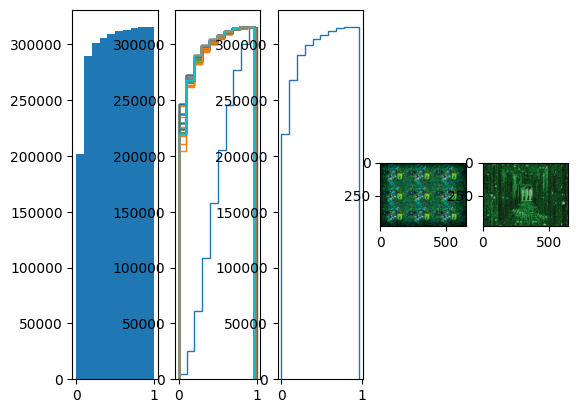

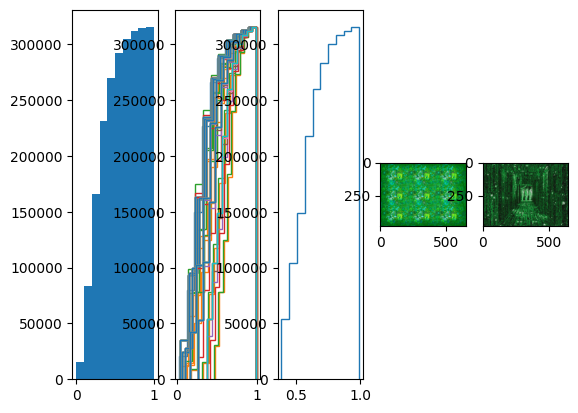

<Figure size 640x480 with 0 Axes>

In [ ]:
colorimage = plt.imread('matrix-1504793816139419323.jpg')
newimage = destimg[30:410, 30:410].astype(float, copy=True)
originalimage = newimage.copy()

newimage = resize(newimage, (colorimage.shape[0], colorimage.shape[1]))

myimage = np.zeros_like(colorimage).astype(float)
for col in range(3):
    srcimg = colorimage[:, :, col]
    srcimg = srcimg / srcimg.max()
    srcimg_lin = srcimg.reshape(srcimg.shape[0] * srcimg.shape[1])
    fig, axs = plt.subplots(1, 5)
    src_bins = axs[0].hist(srcimg_lin, cumulative=True)
    destimg = newimage[:, :, col].reshape(newimage.shape[0] * newimage.shape[1])
    rel = {}
    for itt in range(6):
        for i, v in enumerate(src_bins[0]):
            dest_bins = axs[1].hist(destimg, cumulative=True, histtype='step')
            rel[i] = [src_bins[1][i], src_bins[0][i] / dest_bins[0][i]]
            destimg[destimg > rel[i][0]] = destimg[destimg > rel[i][0]] ** np.sqrt(rel[i][1])
    axs[2].hist(destimg, cumulative=True, histtype='step')
    myimage[:, :, col] = destimg.reshape(srcimg.shape[0], srcimg.shape[1])
    axs[3].imshow(newimage)
    axs[4].imshow(colorimage)
plt.clf()

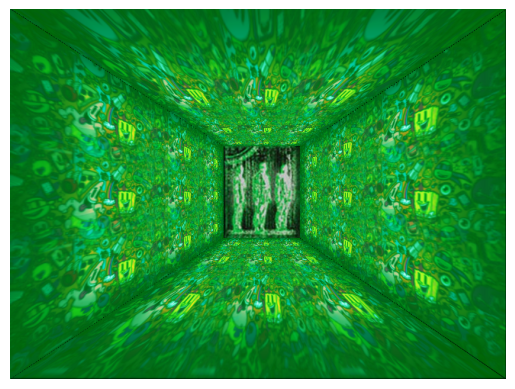

In [ ]:
texture_coords = np.array([[0, 0], [650, 0], [0, 485], [650, 485]])

matrix_coords = np.array([
    [[380, 180], [650, 0], [380, 300], [650, 485]],
    [[0, 0], [650, 0], [280, 180], [380, 180]],
    [[0, 0], [280, 180], [0, 485], [280, 300]],
    [[280, 300], [380, 300], [0, 485], [650, 485]]
])

transforms = [st.ProjectiveTransform() for i in range(4)]

warped_images = [None for i in range(4)]

for i in range(4):
    transforms[i].estimate(texture_coords, matrix_coords[i])
    warped = st.warp(myimage, transforms[i].inverse)
    warped_images[i] = warped


def apply_texture(arr, result, i, j):
    if arr[i][j][0] == 0 and arr[i][j][1] == 0 and arr[i][j][2] == 0:
        pass
    else:
        result[i][j] = arr[i][j]


result = (colorimage / 255).astype(float, copy=True)
for i in range(len(result)):
    for j in range(len(result[i])):
        for k in range(4):
            apply_texture(warped_images[k], result, i, j)

plt.imshow(result.astype(float))
plt.axis('off')
plt.show()